Ticker: AAPL
Amostras treino: 93 | teste: 41
Accuracy:  0.634
Precision: 0.639
Recall:    0.920
F1-score:  0.754
ROC AUC:   0.575

Relatório de Classificação:
              precision    recall  f1-score   support

           0      0.600     0.188     0.286        16
           1      0.639     0.920     0.754        25

    accuracy                          0.634        41
   macro avg      0.619     0.554     0.520        41
weighted avg      0.624     0.634     0.571        41


Coeficientes (ordem decrescente):
rsi_14       0.451
ma_20        0.004
ret_1       -0.116
vol_10      -0.284
ma_5        -0.310
ma_spread   -0.649
dtype: float64


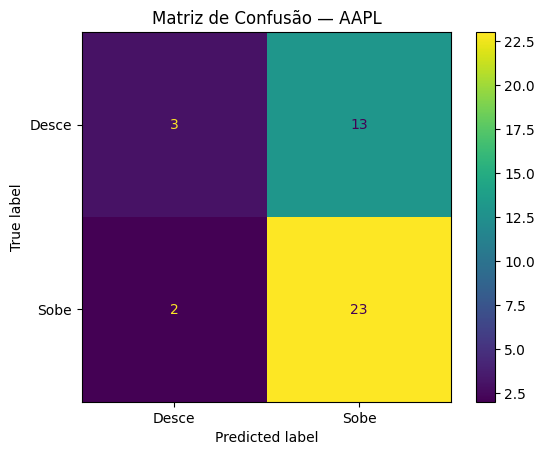

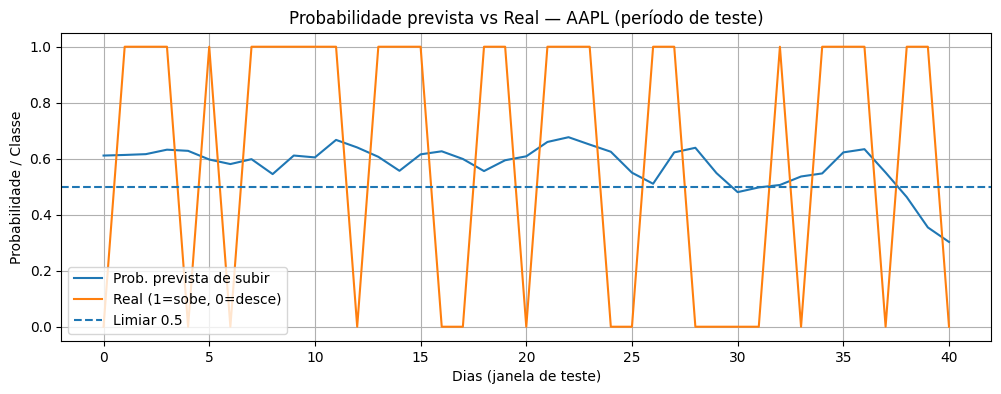

In [17]:
# Se necessário, descomenta:
# !pip install yfinance scikit-learn matplotlib -q

import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
)

# =========================
# 1) Obter dados históricos
# =========================
ticker = "AAPL"   # podes trocar por outra ação do S&P500
df = yf.download(ticker, start="2025-01-01", auto_adjust=True, progress=False)

# Garantir apenas colunas necessárias
df = df[["Close"]].dropna().copy()

# =========================
# 2) Engenharia de features
# =========================
# Retorno diário
df["ret_1"] = df["Close"].pct_change()

# Médias móveis (curta vs longa) e "spread" entre elas
df["ma_5"]  = df["Close"].rolling(5).mean()
df["ma_20"] = df["Close"].rolling(20).mean()
df["ma_spread"] = df["ma_5"] - df["ma_20"]

# Volatilidade: desvio-padrão dos retornos (janela 10)
df["vol_10"] = df["ret_1"].rolling(10).std()

# RSI(14) simples (versão pedagógica)
window_rsi = 14
delta = df["Close"].diff()
gain = (delta.clip(lower=0)).rolling(window_rsi).mean()
loss = (-delta.clip(upper=0)).rolling(window_rsi).mean()
rs = gain / (loss + 1e-9)   # evitar divisão por zero
df["rsi_14"] = 100 - (100 / (1 + rs))

# =========================
# 3) Variável alvo (label)
# =========================
# 1 se o fecho de amanhã for > fecho de hoje, caso contrário 0
df["y_up"] = (df["Close"].shift(-1) > df["Close"]).astype(int)

# =========================
# 4) Limpeza e seleção final
# =========================
features = ["ret_1", "ma_5", "ma_20", "ma_spread", "vol_10", "rsi_14"]
df_model = df[features + ["y_up"]].dropna().copy()

X = df_model[features].values
y = df_model["y_up"].values

# =========================
# 5) Divisão treino/teste (temporal)
# =========================
# Sem baralhar (shuffle=False) para respeitar a ordem temporal
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, shuffle=False
)

# =========================
# 6) Normalização (apenas com treino)
# =========================
scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train)
X_test_sc  = scaler.transform(X_test)

# =========================
# 7) Treinar Reg. Logística
# =========================
logreg = LogisticRegression(max_iter=1000, solver="lbfgs")
logreg.fit(X_train_sc, y_train)

# =========================
# 8) Avaliação
# =========================
y_proba = logreg.predict_proba(X_test_sc)[:, 1]   # prob de “subir”
threshold = 0.5
y_pred = (y_proba >= threshold).astype(int)

acc  = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, zero_division=0)
rec  = recall_score(y_test, y_pred, zero_division=0)
f1   = f1_score(y_test, y_pred, zero_division=0)
auc  = roc_auc_score(y_test, y_proba)

print(f"Ticker: {ticker}")
print(f"Amostras treino: {len(y_train)} | teste: {len(y_test)}")
print(f"Accuracy:  {acc:.3f}")
print(f"Precision: {prec:.3f}")
print(f"Recall:    {rec:.3f}")
print(f"F1-score:  {f1:.3f}")
print(f"ROC AUC:   {auc:.3f}\n")

print("Relatório de Classificação:")
print(classification_report(y_test, y_pred, digits=3))

# Coeficientes (importância dos sinais nas features padronizadas)
coef = pd.Series(logreg.coef_[0], index=features).sort_values(ascending=False)
print("\nCoeficientes (ordem decrescente):")
print(coef.round(3))

# =========================
# 9) Gráficos
# =========================
# a) Matriz de confusão
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Desce", "Sobe"])
disp.plot(values_format="d")
plt.title(f"Matriz de Confusão — {ticker}")
plt.grid(False)
plt.show()

# b) Probabilidade prevista vs. verdade (no tempo de teste)
plt.figure(figsize=(12,4))
plt.plot(y_proba, label="Prob. prevista de subir")
plt.plot(y_test, label="Real (1=sobe, 0=desce)")
plt.axhline(threshold, linestyle="--", label="Limiar 0.5")
plt.title(f"Probabilidade prevista vs Real — {ticker} (período de teste)")
plt.xlabel("Dias (janela de teste)")
plt.ylabel("Probabilidade / Classe")
plt.legend()
plt.grid(True)
plt.show()
